In [83]:
#inicjalizacja bibliotek
import pandas as pd
import numpy as np
from sympy import symbols, Eq, solve
import matplotlib.pyplot as plt
#metrics
from sklearn.metrics import mean_squared_error, r2_score

#GUI
import tkinter as tk

import copy

In [222]:
class point:
    "Power_Element1 - power suply of Element1 target, Power_Element2 - power suply of Element2 target, Concentration_Element1 - concentrations in the middle of sample, total_thickness - total thickness of alloy"
    def __init__(self, Element1, Element2 , Power_Element1, Power_Element2, Concentration_Element1, total_thickness, time, tElement1=None, tElement2=None):
        
        data = {"Co":6.67*10**-6, "Ni":6.59*10**-6, "Au":10.21*10**-6, "Pt":9.09*10**-6, "Tb":1.93*10**-5} # dict with molecular volume of elements
        
        self.Element1 = Element1
        self.Element2 = Element2
        self.Power_Element1 = Power_Element1
        self.Power_Element2 = Power_Element2
        self.Concentration_Element1 = Concentration_Element1
        self.total_thickness = total_thickness
        self.time = time
        
        #inicjalizacja wartości stałych
        self.VElement1 = data[Element1]
        self.VElement2 = data[Element2]
        self.deposition_rate()
        
       
    def thickness(self):
        tElement11, tElement21 = symbols('tElement1, tElement2')
        eq1 = Eq(100*(tElement11/self.VElement1)/((tElement11/self.VElement1) + ((tElement21)/self.VElement2)),self.Concentration_Element1)
        eq2 =  Eq(tElement21 + tElement11,self.total_thickness)
        solved = dict((str(key), float(value)) for (key, value) in solve((eq1,eq2),(tElement11,tElement21)).items())
        self.tElement1  = solved['tElement1'] 
        self.tElement2 = solved['tElement2']
        return solved
    
    def deposition_rate(self):
        try:
            dr_solved = dict((key, value/self.time) for (key, value) in self.thickness().items())
            self.rate_Element1 = dr_solved['tElement1']
            self.rate_Element2 = dr_solved['tElement2']
            return dr_solved
        except ZeroDivisionError as Error:
            print("Time Error")
        

    @staticmethod
    def line(*samples):
        line_param={}
        x = np.linspace(0,70,100)
        #firslty we do list comprehension, after that to flat array to 1D we use sum(list,[]) method, next we transform list to set to get only unique value, and as last we create empty dictionary by another list of comprehension
        element_dict = {i: [] for i in sum([[element.Element1, element.Element2] for element in samples],[])}
        power_dict = copy.deepcopy(element_dict)
        for sample in samples:
            element_dict[sample.Element1].append(sample.rate_Element1)
            element_dict[sample.Element2].append(sample.rate_Element2)
            power_dict[sample.Element1].append(sample.Power_Element1)
            power_dict[sample.Element2].append(sample.Power_Element2)

        for element in element_dict:
            fit = np.polyfit(x=power_dict[element], y=element_dict[element], deg=1)
            fit1D = np.poly1d(fit)
            line_param[f"{element}_slope"] = fit[0]
            line_param[f"{element}_intercept"] = fit[1]

            plt.scatter(x=power_dict[element], y=element_dict[element])
            plt.legend(element_dict.keys())
            plt.plot(x,fit1D(x))
        
        
        return line_param#, plt.show()

    @staticmethod
    def make_df(*B):
        return pd.DataFrame([point.line(*B)])
          

# GUI

In [3]:
class App_window():
    
    def __init__(self, point):
       
        self.point = point
        
        #root initialization
        self.root = tk.Tk()
        self.root.title("Sputtering Calibration")
        self.root.geometry("600x600")
        self.logic = False
        self.logic2 = False
        #cordinations initialization
        self.x, self.y = 0.2, 0.1 
        #self.check_var = True
        self.entry_list = []
        #elements of windows first frame
        self.start_frame()
        self.Add()
        self.create_field()
        self.root.mainloop()
        
        
     
    def start_frame(self):
        self.text = tk.Label(text="Please enter value of: \n PTb [W], PCo [W], cTb [at.%], tTbco [A]", font=("", 10))
        self.text.place(relx=self.x, rely=self.y, anchor='center')
        
        self.button_exit = tk.Button(text="EXIT", command = self._exit)
        self.button_exit.place(relx=0.1, rely=0.9, anchor='sw')
        
        self.button_calculate = tk.Button(text="Calculate", command = self.calculate)
        self.button_calculate.place(relx=0.5, rely=0.3)
        
    def Add(self):
        if self.logic:
                self.entry_list.append(self.entry.get())
        else:
            self.logic=True
        #self.entry_list.append(self.entry.get()) if self.logic else self.logic=True  #save values from entry into entry_list
        self.button_new = tk.Button(text="Add new point", command= self.create_field)
        self.button_new.place(relx = self.x+0.07, rely= self.y+0.05)
        
"""        
    def create_field(self):
        
        #self.button1.place(relx= self.x-0.1, rely= self.y+0.05)
        if self.logic2:
                self.entry_list.append(self.entry.get())
        else:
            self.logic2=True
        self.entry = tk.Entry()
        self.entry.place(relx= self.x-0.15, rely= self.y+0.055)
        
        self.y += 0.05
        self.y += 0.05
        #self.button_check = tk.Button(text="✅", height= 1,command=self.check)
        #self.button_check.place(relx= self.x_but2, rely=self.y_ent)
"""        
    def calculate(self):
        self.entry_list.append(self.entry.get()) #save values from entry into entry_list
        self.text2 = tk.Label(text=f"{self.entry_list}", font=("", 10))
        self.text2.place(relx=0.5, rely=0.5)
        self.entry_list.pop() #prevent addint new element to entry_list by multiple clicking of calculate button
       
    def _exit(self):
        self.root.quit()  # stops mainloop
        self.root.destroy()  # this is necessary on Windows to preven


            

App_window(point)

In [196]:
Ni1 = point("Ni","Au",10,50, 5.5,1450,1000)
Ni2 = point("Ni","Au",15,60,6.8,1776,1000)
Ni3 = point("Ni","Au",20,70,8.3,2076,1000)

In [124]:
a=point.line(Ni1,Ni2,Ni3)
df=pd.DataFrame([a])
df

,Ni_slope,Ni_intercept,Co_slope,Co_intercept,Au_slope,Au_intercept
0,0.000206,0.076787,0.041842,-0.720935,0.026397,0.112281


In [192]:
Pt1 = point("Co","Pt",10,50,9.2,1000,1000)
Pt2 = point("Co","Pt",20,60,15,1245,1000)
Pt3 = point("Co","Pt",30,70,19.6,1614,1000)

In [179]:
p1 = point("Co","Pt",15,50,12,1096,1000)
p2 = point("Co","Pt",30,60,20,1439,1000)
p3 = point("Co","Pt",15,37.5,17.5,442,500)

{'Co_slope': 0.008785094539355592,
 'Co_intercept': -0.02342250935475614,
 'Pt_slope': 0.021914905460644393,
 'Pt_intercept': -0.18084037573768583,
 'Ni_slope': 0.006208950365324364,
 'Ni_intercept': -0.010814089567762758,
 'Au_slope': 0.02819552481733782,
 'Au_intercept': -0.006718321619038252}

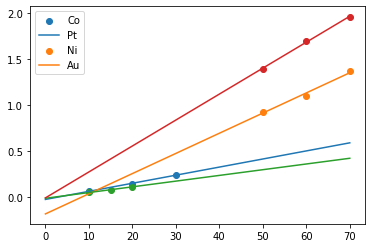

In [223]:
point.line(Pt1, Pt2, Pt3, Ni1, Ni2, Ni3)


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3369: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


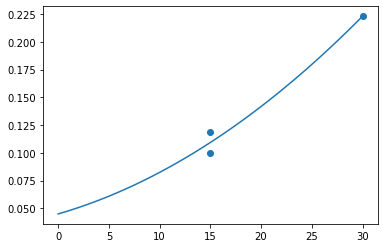

In [189]:
y = [0.09969071321423723, 0.22305670462468088, 0.1190617896498012]
x = [15, 30, 15]

plt.scatter(x,y)

plt.plot(np.linspace(0,30,100),np.poly1d(np.polyfit(x,y, deg=2))(np.linspace(0,30,100)))

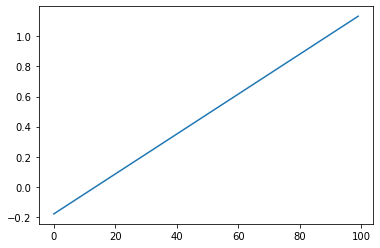

In [169]:
x= np.linspace(0,60,100)
plt.plot(fit1D(x))
plt.show()

In [8]:
p1.thickness()
p3.thickness()

{'tTb': 59.5308948249006, 'tCo': 382.4691051750994}

In [11]:
x= np.linspace(0,50,1000)
y1 = x*0.008224399427362911-0.02367527819620648
y2 = x*0.004786-0.006355
y3 = x*0.007579--0.004304

In [7]:
import matplotlib.pyplot as plt

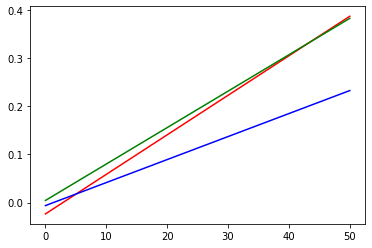

In [12]:
plt.plot(x,y1,"r")
plt.plot(x,y2, "b")
plt.plot(x,y3,"g")
plt.show()

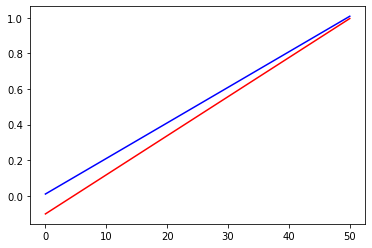

In [14]:
pt1 = x*0.021963-0.101861
pt2 = x*0.019982+0.00996
plt.plot(x,pt1,"r")
plt.plot(x,pt2, "b")
plt.show()